Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Содержание проекта  <a class="anchor" id="0-bullet">
* [Шаг 1. Подготовка данных](#1-bullet)
* [Шаг 2. Обучение моделей](#2-bullet)
* [Шаг 3. Анализ моделей](#3-bullet)

# 1. Подготовка данных<a class="anchor" id="1-bullet"></a>
👈[назад к оглавлению](#0-bullet)

In [1]:
# Импортируем библиотеки

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import Pool, CatBoostRegressor, cv

In [2]:
datasets_path = ''
datasets_path = 'C:/Users/Venik/Documents/Copy_Yandex_Praktikum/_git_YP/Numeric_Methods'

In [3]:
autos_dataset = pd.read_csv(datasets_path + '/datasets/autos.csv')
autos_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
autos_dataset.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
307119,2016-03-11 18:49:10,0,sedan,2000,manual,107,NaN,150000,12,NaN,renault,yes,2016-03-11 00:00:00,0,2899,2016-03-12 09:16:07
200590,2016-03-15 17:27:34,1100,NaN,2016,NaN,75,lupo,150000,0,petrol,volkswagen,NaN,2016-03-15 00:00:00,0,56457,2016-03-16 09:27:34
316803,2016-03-24 15:47:06,1950,sedan,2002,auto,103,other,125000,9,petrol,suzuki,no,2016-03-24 00:00:00,0,40599,2016-04-07 07:45:52
111505,2016-03-19 19:49:56,300,sedan,1997,manual,75,astra,150000,10,petrol,opel,yes,2016-03-19 00:00:00,0,56235,2016-03-22 16:22:10
218740,2016-03-11 11:25:19,8888,wagon,2000,auto,354,e_klasse,150000,10,lpg,mercedes_benz,no,2016-03-11 00:00:00,0,55116,2016-04-05 19:18:22


In [5]:
autos_dataset['PostalCode'].value_counts()

10115    819
65428    613
66333    343
44145    317
32257    317
        ... 
6725       1
6922       1
85071      1
97528      1
63931      1
Name: PostalCode, Length: 8143, dtype: int64

In [6]:
autos_dataset['RegistrationMonth'].value_counts()

0     37352
3     34373
6     31508
4     29270
5     29153
7     27213
10    26099
12    24289
11    24186
9     23813
1     23219
8     22627
2     21267
Name: RegistrationMonth, dtype: int64

**Проанализируем числовые параметры в выборке**

In [7]:
# Функция для заполнения параметров гистограммы 
def df_hystogram(series,
                 series_name,
                 description_name,
                 diagram_color,
                 bins_number):
    
    plt.figure(0)
    n, bins, patches = plt.hist(series, 
                                   bins_number, 
                                   density=True, 
                                   facecolor=diagram_color, 
                                   label = series_name, 
                                   alpha=0.3)
    
    series_description = series.describe()
    
    y = scs.norm.pdf(bins, series_description[1], series_description[2])

    #plt.plot(bins, y, '--'+diagram_color)

    plt.xlabel(series_name)
    plt.ylabel('Частота в выборке')

    plt.gca().set(title=description_name)
        
    plt.legend()
    plt.grid()
    plt.plot(bins)
    #plt.plot()

    return series_description

# Функция для формирования диаграммы из датафрейма
def df_histogram(dataframe, 
                frame_name, 
                diagram_name, 
                column_name,
                color_in,
                bins_in,
                y_label):

    plt.figure(0, figsize=(8,5), dpi= 80)
    
    plt.grid()

    plt.gca().set(title=diagram_name , ylabel=y_label)

    plt.hist(dataframe[column_name], bins=bins_in, color = color_in, label = frame_name, alpha = 0.5)

    plt.legend()
    plt.plot()


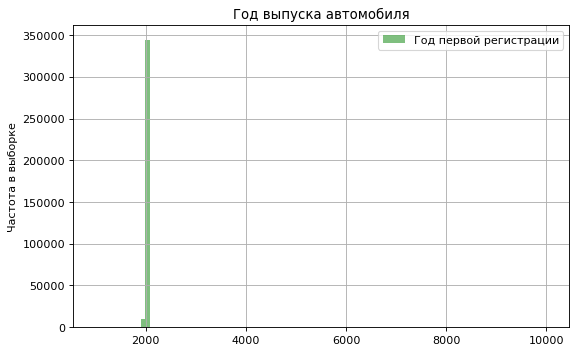

In [8]:
df_histogram(autos_dataset,
             'Год первой регистрации',
             'Год выпуска автомобиля',
             'RegistrationYear',
             'g',
             100,
             'Частота в выборке')

In [9]:
autos_dataset.query('(RegistrationYear < 1950)|(RegistrationYear > 2020)')['RegistrationYear'].value_counts()

1910    101
1000     37
9999     26
5000     17
1937     11
       ... 
5900      1
8455      1
2290      1
9450      1
4100      1
Name: RegistrationYear, Length: 81, dtype: int64

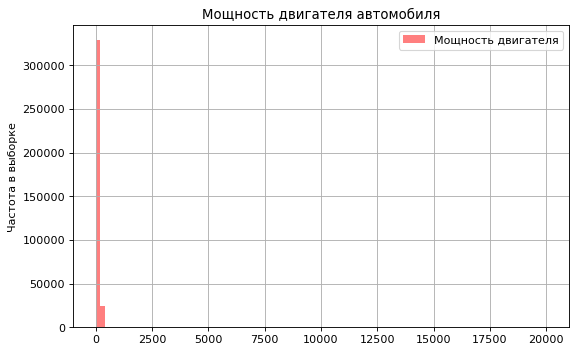

In [10]:
df_histogram(autos_dataset,
             'Мощность двигателя',
             'Мощность двигателя автомобиля',
             'Power',
             'r',
             100,
             'Частота в выборке')

In [11]:
autos_dataset.query('Power > 500')['Power'].value_counts()

507     13
600     10
1800     8
1598     8
1000     8
        ..
4400     1
9007     1
5420     1
776      1
1024     1
Name: Power, Length: 299, dtype: int64

In [12]:
autos_dataset['Kilometer'].value_counts()

150000    238209
125000     36454
100000     14882
90000      11567
80000      10047
70000       8593
60000       7444
5000        6397
50000       6232
40000       4911
30000       4436
20000       3975
10000       1222
Name: Kilometer, dtype: int64

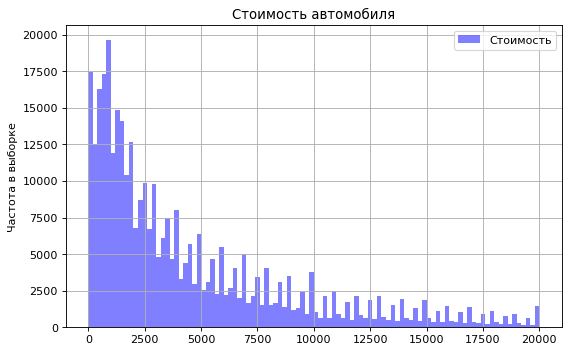

In [13]:
df_histogram(autos_dataset,
             'Стоимость',
             'Стоимость автомобиля',
             'Price',
             'b',
             100,
             'Частота в выборке')

### <span style="color:green">Что мы видим в данных:<span>

1. Есть незаполненные поля 'VehicleType' (тип кузова), 'Gearbox' (коробка передач), 'Model' (модель автомобиля), 'FuelType' (Тип топлива), 'NotRepaired' (была ли в ремонте).
2. Есть ряд полей, которые никак не повлияют на прогноз цены продажи автомобиля, например 'DateCrawled' (дата скачивания анкеты), 'LastSeen' (дата последней активности), 'NumberOfPictures' (количество фотографий). От количества фотографий скорее зависит скорость продажи, остальные не очень информативны.
3. Также в нескольких числовых колонках, влияющих на стоимость есть нулевые значения, например 'Power' (мощность двигателя) и 'RegistrationMonth' (месяц регистрации). Нули есть и в целевом признаке.
4. 'PostalCode' можно было бы рассматривать как регион продажи автомобиля. Однако в российском индексном классификаторе длина индекса шесть знаков, а проведя поиск по некоторым индексам я обнаружил, что география их достаточно широкая - от Германии до США. Учитывая, что даже в США в различных штатах стоимость автомобиля может различаться, этот параметр может влиять на целевой признак.
5. В числовых колонках 'Power' и 'RegistrationYear' есть аномальные значения.

### <span style="color:green">Стратегия подготовки данных:<span>

1. Удалим неинформативные для обучения модели колонки.
2. Удалим строки, в которых не указана модель автомобиля, т.к. заполнить по остальным данным мы ее можем лишь косвенно, а это не улучшит данные. К тому же у производителей обычно достаточно широкий модельный ряд и без указания модели пользователь никак не получит точную цену, а у нас именно такая цель.
3. Также удалим строки, в которых целевой признак равен нулю. Они не помогут обучению модели, скорее всего это ошибки ввода данных. Заполнять их какими-то значениями не корректно.
4. Удалим строки с аномальными значениями 'Power' (более 500 л.с., большей мощности у легковых автомобилей точно нет) и 'RegistrationYear' (менее 1950 и более 2020). Очевидно, что массовой регистрации быть не могло, а сейчас 2020 год.
5. Нулевые значения колонках 'Power' и 'RegistrationMonth' заполним наиболее частыми значениями с отобром по колонкам 'RegistrationYear', 'Brand', 'Model'.
6. Незаполненные признаки в колонке 'FuelType' заполним наиболее частыми значениями с отобром по колонкам  'RegistrationYear', 'RegistrationMonth', 'Brand', 'Model' и 'Power'.
7. Незаполненные признаки в колонках 'VehicleType', 'Gearbox', 'NotRepaired' трогать не будем. Это признак индивидуальный, пусть модель рассматривает их как отдельную категорию.
8. Индекс переведем в строку, чтобы модель рассматравала его как категориальную переменную.
9. Проверим, везде ли корректно указан год регистрации автомобиля
9. Из колонок 'DateCreated' и 'RegistrationYear' и 'RegistrationMonth' создадим признак 'MonthsOld', позволяющий определить возраст автомобиля на момент продажи. Это должно быть более информативно для модели. Признаки 'RegistrationYear' и 'RegistrationMonth' после этого преобразуем в единую категориальную переменную, а 'DateCreated' - удалим.

In [14]:
# Удалим неинформативные колонки, строки с отсутствующей моделью и нулевым целевым признаком
autos_dataset.drop(['DateCrawled', 'LastSeen', 'NumberOfPictures'], axis = 1, inplace = True)

# Для этого заполним нули значениями numpy.nan
autos_dataset.loc[autos_dataset['Price'] == 0, 'Price'] = np.nan

autos_dataset.dropna(subset=['Model', 'Price'], inplace=True)
#autos_dataset.dropna(subset=['Model'], inplace=True)
#autos_dataset.dropna(subset=['Price'], inplace=True)
autos_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326076 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              326076 non-null  float64
 1   VehicleType        297910 non-null  object 
 2   RegistrationYear   326076 non-null  int64  
 3   Gearbox            311806 non-null  object 
 4   Power              326076 non-null  int64  
 5   Model              326076 non-null  object 
 6   Kilometer          326076 non-null  int64  
 7   RegistrationMonth  326076 non-null  int64  
 8   FuelType           302525 non-null  object 
 9   Brand              326076 non-null  object 
 10  NotRepaired        267783 non-null  object 
 11  DateCreated        326076 non-null  object 
 12  PostalCode         326076 non-null  int64  
dtypes: float64(1), int64(5), object(7)
memory usage: 34.8+ MB


In [15]:
# Удалим аномальные значения в колонках 'RegistrationYear' и 'Power'
autos_dataset = autos_dataset.query('(RegistrationYear >= 1950)&(RegistrationYear <= 2020)&(Power <= 500)')

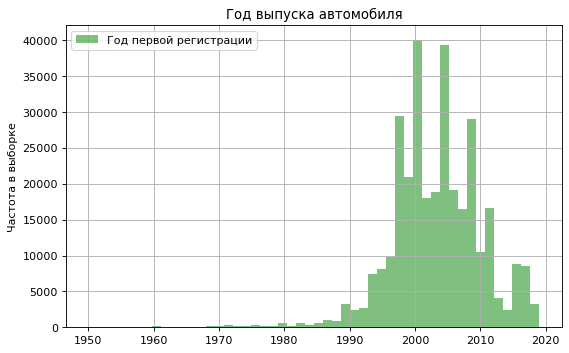

In [16]:
df_histogram(autos_dataset,
             'Год первой регистрации',
             'Год выпуска автомобиля',
             'RegistrationYear',
             'g',
             50,
             'Частота в выборке')

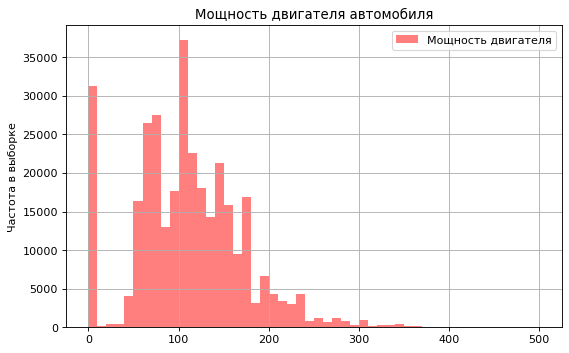

In [17]:
df_histogram(autos_dataset,
             'Мощность двигателя',
             'Мощность двигателя автомобиля',
             'Power',
             'r',
             50,
             'Частота в выборке')

In [18]:
# Заполним нулевые значения колонках 'Power' и 'RegistrationMonth'

# Для этого заполним нули значениями numpy.nan
autos_dataset.loc[autos_dataset['Power'] == 0, 'Power'] = np.nan
autos_dataset.loc[autos_dataset['RegistrationMonth'] == 0, 'RegistrationMonth'] = np.nan

# Затем заполним их наиболее часто встречающимся значением
array_for_change = autos_dataset[['Power','RegistrationMonth','RegistrationYear','Brand', 'Model']].values
imputer = SimpleImputer(strategy='most_frequent')
array_transformed = imputer.fit_transform(array_for_change)

# Перезапишем колонки
autos_dataset['Power'] = array_transformed[:,0]
autos_dataset['RegistrationMonth'] = array_transformed[:,1]

autos_dataset['Power'] = autos_dataset['Power'].astype('int64')
autos_dataset['RegistrationMonth'] = autos_dataset['RegistrationMonth'].astype('int64')

autos_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325549 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              325549 non-null  float64
 1   VehicleType        297534 non-null  object 
 2   RegistrationYear   325549 non-null  int64  
 3   Gearbox            311384 non-null  object 
 4   Power              325549 non-null  int64  
 5   Model              325549 non-null  object 
 6   Kilometer          325549 non-null  int64  
 7   RegistrationMonth  325549 non-null  int64  
 8   FuelType           302152 non-null  object 
 9   Brand              325549 non-null  object 
 10  NotRepaired        267497 non-null  object 
 11  DateCreated        325549 non-null  object 
 12  PostalCode         325549 non-null  int64  
dtypes: float64(1), int64(5), object(7)
memory usage: 34.8+ MB


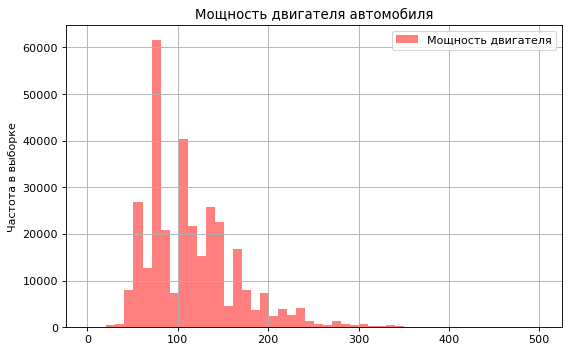

In [19]:
df_histogram(autos_dataset,
             'Мощность двигателя',
             'Мощность двигателя автомобиля',
             'Power',
             'r',
             50,
             'Частота в выборке')

In [20]:
# Заполним нулевые значения колонке 'FuelType' часто встречающимся значением
array_for_change = autos_dataset[['FuelType', 'Power','RegistrationMonth','RegistrationYear','Brand', 'Model']].values
imputer = SimpleImputer(strategy='most_frequent')
array_transformed = imputer.fit_transform(array_for_change)

# Перезапишем колонки
autos_dataset['FuelType'] = array_transformed[:,0]

autos_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325549 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              325549 non-null  float64
 1   VehicleType        297534 non-null  object 
 2   RegistrationYear   325549 non-null  int64  
 3   Gearbox            311384 non-null  object 
 4   Power              325549 non-null  int64  
 5   Model              325549 non-null  object 
 6   Kilometer          325549 non-null  int64  
 7   RegistrationMonth  325549 non-null  int64  
 8   FuelType           325549 non-null  object 
 9   Brand              325549 non-null  object 
 10  NotRepaired        267497 non-null  object 
 11  DateCreated        325549 non-null  object 
 12  PostalCode         325549 non-null  int64  
dtypes: float64(1), int64(5), object(7)
memory usage: 34.8+ MB


In [21]:
# Преобразуем почтовый индекс в строковую переменную
autos_dataset['PostalCode'] = autos_dataset['PostalCode'].astype('category') 

autos_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325549 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Price              325549 non-null  float64 
 1   VehicleType        297534 non-null  object  
 2   RegistrationYear   325549 non-null  int64   
 3   Gearbox            311384 non-null  object  
 4   Power              325549 non-null  int64   
 5   Model              325549 non-null  object  
 6   Kilometer          325549 non-null  int64   
 7   RegistrationMonth  325549 non-null  int64   
 8   FuelType           325549 non-null  object  
 9   Brand              325549 non-null  object  
 10  NotRepaired        267497 non-null  object  
 11  DateCreated        325549 non-null  object  
 12  PostalCode         325549 non-null  category
dtypes: category(1), float64(1), int64(4), object(7)
memory usage: 33.3+ MB


In [22]:
# Сформируем признак 'MonthsOld', позволяющий определить возраст автомобиля на момент продажи

# Преобразуем колонку с датой регистрации объявления в дату
autos_dataset['DateCreated_DateTime'] = pd.to_datetime(autos_dataset['DateCreated'], format='%Y-%m-%d %H:%M:%S')

# Сформируем колонки с месяцем и годом создания
def MonthOfCreation(row):
    return row['DateCreated_DateTime'].month

def YearOfCreation(row):
    return row['DateCreated_DateTime'].year

autos_dataset['CreationYear'] = autos_dataset.apply(YearOfCreation, axis = 1)
autos_dataset['CreationMonth'] = autos_dataset.apply(MonthOfCreation, axis = 1)

In [23]:
# Проверим, нет ли аномалий в году и месяце регистрации
autos_dataset['CreationYear'].value_counts()

2016    325524
2015        24
2014         1
Name: CreationYear, dtype: int64

In [24]:
autos_dataset['CreationMonth'].value_counts()

3     272570
4      52526
2        368
1         62
12         9
11         8
9          3
8          2
6          1
Name: CreationMonth, dtype: int64

In [25]:
autos_dataset.query('RegistrationYear > CreationYear').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11842 entries, 22 to 354289
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Price                 11842 non-null  float64       
 1   VehicleType           18 non-null     object        
 2   RegistrationYear      11842 non-null  int64         
 3   Gearbox               10527 non-null  object        
 4   Power                 11842 non-null  int64         
 5   Model                 11842 non-null  object        
 6   Kilometer             11842 non-null  int64         
 7   RegistrationMonth     11842 non-null  int64         
 8   FuelType              11842 non-null  object        
 9   Brand                 11842 non-null  object        
 10  NotRepaired           6817 non-null   object        
 11  DateCreated           11842 non-null  object        
 12  PostalCode            11842 non-null  category      
 13  DateCreated_Da

#### <span style="color:darkblue">В процессе преобразования датасета было обнаружено несоответствие года публикации объявления и года регистрации автомобиля. Год регистрации никак не может быть больше. Заменить эти значения не представляется возможным. Просто удалим эти строки. А затем посмотрим как отличается месяц публикации при равенстве года. Предполагаем, что там также есть аномалии. Если таковые возникнут, трогать их не будем, при дальнейшем расчете показателя количества месяцев использования заменим отрицательные значения на 0<span>

In [26]:
autos_dataset = autos_dataset.query('RegistrationYear <= CreationYear')
autos_dataset.sample(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,DateCreated_DateTime,CreationYear,CreationMonth
186356,950.0,small,2007,manual,60,ka,150000,1,petrol,ford,NaN,2016-03-22 00:00:00,24980,2016-03-22,2016,3
110052,2900.0,sedan,2007,manual,105,golf,150000,6,gasoline,volkswagen,no,2016-03-25 00:00:00,86415,2016-03-25,2016,3
63719,13500.0,coupe,2011,auto,156,other,125000,4,petrol,peugeot,no,2016-03-09 00:00:00,91052,2016-03-09,2016,3
305474,3990.0,coupe,2007,manual,109,c4,150000,5,gasoline,citroen,no,2016-03-21 00:00:00,22955,2016-03-21,2016,3
329861,1500.0,sedan,2002,manual,141,6_reihe,150000,7,petrol,mazda,no,2016-03-08 00:00:00,49086,2016-03-08,2016,3


In [27]:
autos_dataset.query('(RegistrationYear == CreationYear)&(RegistrationMonth > CreationMonth)').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4341 entries, 31 to 354361
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Price                 4341 non-null   float64       
 1   VehicleType           18 non-null     object        
 2   RegistrationYear      4341 non-null   int64         
 3   Gearbox               3955 non-null   object        
 4   Power                 4341 non-null   int64         
 5   Model                 4341 non-null   object        
 6   Kilometer             4341 non-null   int64         
 7   RegistrationMonth     4341 non-null   int64         
 8   FuelType              4341 non-null   object        
 9   Brand                 4341 non-null   object        
 10  NotRepaired           2575 non-null   object        
 11  DateCreated           4341 non-null   object        
 12  PostalCode            4341 non-null   category      
 13  DateCreated_Dat

In [28]:
def MonthOld(row):
    MonthsOfRegistration = (row['RegistrationYear'] - 1) * 12 + row['RegistrationMonth']
    MonthsOfCreation = (row['CreationYear'] - 1) * 12 + row['CreationMonth']

    YearsOld = MonthsOfCreation - MonthsOfRegistration
    if YearsOld < 0:
        YearsOld = 0

    return YearsOld

autos_dataset['MonthsOld'] = autos_dataset.apply(MonthOld, axis = 1)

# Преобразуем месяц и год регистрации в категориальную переменную
autos_dataset['YearMonthOfRegistration'] = (autos_dataset['RegistrationYear'].astype('str') + 
                                            '/' + autos_dataset['RegistrationMonth'].astype('str'))

# Удалим лишние колонки
autos_dataset.drop(['DateCreated_DateTime', 
                    'DateCreated', 
                    'RegistrationYear', 
                    'RegistrationMonth'], axis = 1, inplace = True)

autos_dataset.sample(5)

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,PostalCode,CreationYear,CreationMonth,MonthsOld,YearMonthOfRegistration
15832,11950.0,bus,manual,125,c_max,60000,petrol,ford,no,35745,2016,4,39,2013/1
74858,3000.0,sedan,manual,95,c_klasse,150000,petrol,mercedes_benz,no,22309,2016,3,184,2000/11
118872,5580.0,small,auto,116,cooper,150000,petrol,mini,NaN,57392,2016,3,153,2003/6
83164,600.0,sedan,manual,133,80,150000,petrol,audi,NaN,86554,2016,3,285,1992/6
136804,9300.0,wagon,auto,111,3_reihe,50000,gasoline,peugeot,no,9337,2016,3,44,2012/7


In [29]:
# Заполним нулевые значения колонкax 'Gearbox' значением 'None' (catboost без этого не взлетает)
array_for_change = autos_dataset[['VehicleType','Gearbox','NotRepaired']].values
imputer = SimpleImputer(strategy='constant',fill_value = 'None')
array_transformed = imputer.fit_transform(array_for_change)

# Перезапишем колонки
autos_dataset['VehicleType'] = array_transformed[:,0]
autos_dataset['Gearbox'] = array_transformed[:,1]
autos_dataset['NotRepaired'] = array_transformed[:,2]

autos_dataset['VehicleType'] = autos_dataset['VehicleType'].astype('category') 
autos_dataset['Gearbox'] = autos_dataset['Gearbox'].astype('category') 
autos_dataset['Model'] = autos_dataset['Model'].astype('category') 
autos_dataset['FuelType'] = autos_dataset['FuelType'].astype('category') 
autos_dataset['Brand'] = autos_dataset['Brand'].astype('category') 
autos_dataset['NotRepaired'] = autos_dataset['NotRepaired'].astype('category') 
autos_dataset['YearMonthOfRegistration'] = autos_dataset['YearMonthOfRegistration'].astype('category') 

autos_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 313707 entries, 0 to 354368
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   Price                    313707 non-null  float64 
 1   VehicleType              313707 non-null  category
 2   Gearbox                  313707 non-null  category
 3   Power                    313707 non-null  int64   
 4   Model                    313707 non-null  category
 5   Kilometer                313707 non-null  int64   
 6   FuelType                 313707 non-null  category
 7   Brand                    313707 non-null  category
 8   NotRepaired              313707 non-null  category
 9   PostalCode               313707 non-null  category
 10  CreationYear             313707 non-null  int64   
 11  CreationMonth            313707 non-null  int64   
 12  MonthsOld                313707 non-null  int64   
 13  YearMonthOfRegistration  313707 non-null  ca

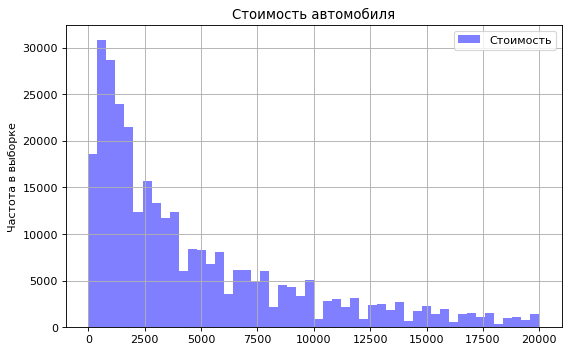

In [30]:
df_histogram(autos_dataset,
             'Стоимость',
             'Стоимость автомобиля',
             'Price',
             'b',
             50,
             'Частота в выборке')

### <span style="color:green">Выводы по результатам подготовки данных<span>

Мы получили датасет, содержащий только признаки, которые реально могут влиять на цену автомобиля. Объем датасета за счет ошибок в данных сократился, примерно на 11%.

**Числовые параметры:**
    
    - мощность двигателя;
    - пробег, км;
    - возраст автомобиля на момент размещения объявления в месяцах;
    
**Категориальные параметры:** 
    
    - тип кузова;
    - тип коробки передач;
    - модель автомобиля;
    - тип топлива;
    - марка автомобиля;
    - признак того, был ли автомобиль в ремонте;
    - год и месяц первой регистрации.
    
<span style="color:blue">Приступим к обучению моделей<span>

# 2. Обучение моделей<a class="anchor" id="2-bullet"></a>
👈[назад к оглавлению](#0-bullet)

#### <span style="color:darkblue">Для обучения возьмем две модели - LightGBM и CatBoost, т.к. они хорошо работают с категориальными переменными. У нас три целевых параметра. Все параметры мы запишем в отдельный датасет из которого затем выберем лучшие значения. Первый по значимости параметр - точность предсказания, второй - время предсказания, т.к. от этих параметров зависит удовлетворенность пользователей сервиса. Третий параметр - время обучения, он также важен.<span>

### <span style="color:green">План обучения моделей<span>

<span style="color:orange">
    
1. Разобъем данные на обучающую и тестовую выборки в соотношении 75:25.
2. На обучающей выборке проведем обучение моделей методом кросс-валидации (для вычисления лучшей метрики RMSE).
3. Еще раз обучим каждую модель с лучшими параметрами чтобы замерить время обучения.
4. Выполним предсказания на тестовой выборке и замерим время предсказания для каждой из моделей.
5. Отдельно обучим для сравнения линейную регрессию. Для нее придется немного доработать датасет (преобразовать категориальные переменные). Заодно проверим, каким образом работают с преобразованным датасетом модели градиентного бустинга.

<span>

In [31]:
# Разобъем данные и выделим целевые признаки

target_autos_dataset = autos_dataset['Price']
features_autos_dataset = autos_dataset.drop(['Price'] , axis=1)

features_train_valid, features_autos_test, target_train_valid, target_autos_test = train_test_split(features_autos_dataset, 
                                                                                                      target_autos_dataset, 
                                                                                                      test_size=0.25, 
                                                                                                      random_state=12345)

In [32]:
features_autos_dataset.sample(5)

,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,PostalCode,CreationYear,CreationMonth,MonthsOld,YearMonthOfRegistration
143344,small,manual,50,arosa,150000,petrol,seat,None,53121,2016,4,157,2003/3
871,bus,manual,105,golf,70000,gasoline,volkswagen,no,86529,2016,3,53,2011/10
244700,small,manual,75,astra,150000,petrol,opel,no,6901,2016,3,276,1993/3
306502,small,manual,64,polo,100000,petrol,volkswagen,no,14476,2016,4,157,2003/3
126375,convertible,manual,192,spider,150000,petrol,alfa_romeo,no,50374,2016,3,227,1997/4


In [33]:
# создадим датасет с преобразованными категориальными переменными для обучения линейной регрессии
features_autos_dataset_wo_cat = features_autos_dataset

# Переменные VehicleType, Model, Brand, PostalCode и YearMonthOfRegistration преобразуем при помощи метода LabelEncoder
# Переменные Gearbox, FuelType и NotRepaired - при помощи dummy-кодирования

le = preprocessing.LabelEncoder()

new_array = le.fit_transform(features_autos_dataset_wo_cat['VehicleType'].values)
features_autos_dataset_wo_cat['VehicleType'] = new_array

new_array = le.fit_transform(features_autos_dataset_wo_cat['Model'].values)
features_autos_dataset_wo_cat['Model'] = new_array

new_array = le.fit_transform(features_autos_dataset_wo_cat['Brand'].values)
features_autos_dataset_wo_cat['Brand'] = new_array

new_array = le.fit_transform(features_autos_dataset_wo_cat['PostalCode'].values)
features_autos_dataset_wo_cat['PostalCode'] = new_array

new_array = le.fit_transform(features_autos_dataset_wo_cat['YearMonthOfRegistration'].values)
features_autos_dataset_wo_cat['YearMonthOfRegistration'] = new_array

features_autos_dataset_wo_cat = pd.get_dummies(features_autos_dataset_wo_cat, drop_first = True)

features_autos_dataset_wo_cat.sample(5)

,VehicleType,Power,Model,Kilometer,Brand,PostalCode,CreationYear,CreationMonth,MonthsOld,YearMonthOfRegistration,Gearbox_auto,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,NotRepaired_no,NotRepaired_yes
251656,5,150,241,125000,2,5019,2016,3,108,612,0,1,0,1,0,0,0,0,1,0
285337,2,150,11,150000,2,1466,2016,3,226,494,0,1,0,0,0,0,0,1,1,0
280702,5,90,20,150000,1,6357,2016,4,258,452,0,1,0,0,0,0,0,1,1,0
90434,1,131,204,150000,37,3732,2016,3,153,567,0,1,0,1,0,0,0,0,1,0
348557,3,102,11,150000,2,3940,2016,3,202,518,0,1,0,0,0,0,0,1,1,0


In [34]:
# Создадим сравнительный датасет в который будем писать параметры модели
compare = {'model_name' : [],
           'dataset_type' : [],
           'param1_name' : [],
           'param1_value' : [],
           'param2_name' : [],
           'param2_value' : [],
           'learning_time' : [],
           'predicting_time' : [],
           'rmse' : []
           }

compare_data_models = pd.DataFrame(compare)

In [35]:
# Функция для добавления строки в сравнительную таблицу
def add_model_params(model_name,
                     dataset_type,
                     param1_name,
                     param1_value,
                     param2_name,
                     param2_value,
                     learning_time,
                     predicting_time,
                     rmse,
                     compare_data):
    
    compare_data = compare_data.append(pd.DataFrame([[model_name, 
                                                      dataset_type,
                                                      param1_name,
                                                      param1_value,
                                                      param2_name,
                                                      param2_value,
                                                      learning_time,
                                                      predicting_time,
                                                      rmse]], 
                                                      columns = ['model_name', 
                                                                 'dataset_type',
                                                                 'param1_name',
                                                                 'param1_value',
                                                                 'param2_name',
                                                                 'param2_value',
                                                                  'learning_time',
                                                                 'predicting_time',
                                                                 'rmse']),
                                                      ignore_index=True)
    
    return compare_data

In [36]:
# Запишем в таблицу параметры для константной модели, для сравнения

median_predictions = np.full(len(target_autos_test), target_autos_test.mean())

rmse = mean_squared_error(target_autos_test, median_predictions) ** 0.5

compare_data_models = add_model_params('Constant model', 
                                        'without categories', 
                                        'None', 
                                        0,
                                        'None', 
                                        0,
                                        0,
                                        0,
                                        rmse,
                                        compare_data_models) 

compare_data_models

,model_name,dataset_type,param1_name,param1_value,param2_name,param2_value,learning_time,predicting_time,rmse
0,Constant model,with categories,None,0.0,None,0.0,0.0,0.0,4550.519268


In [37]:
ftrwocat_train_valid, ftrwocat_autos_test, trgwocat_train_valid, trgwocat_autos_test = train_test_split(features_autos_dataset_wo_cat, 
                                                                                                      target_autos_dataset, 
                                                                                                      test_size=0.25, 
                                                                                                      random_state=12345)

# Обучим модель с лучшими параметрами, заодно замерим время
model = LinearRegression()    

learning_time = %timeit -n1 -r1 -o model.fit(ftrwocat_train_valid,trgwocat_train_valid)
                    
predicting_time = %timeit -n1 -r1 -o model.predict(ftrwocat_autos_test)
                
predictions_test = model.predict(ftrwocat_autos_test)

rmse = mean_squared_error(trgwocat_autos_test, predictions_test) ** 0.5

compare_data_models = add_model_params('LinearRegression', 
                                        'without categories', 
                                        'None', 
                                        0,
                                        'None',
                                        0,
                                        learning_time.best,
                                        predicting_time.best,
                                        rmse,
                                        compare_data_models) 

compare_data_models

119 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
10.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


,model_name,dataset_type,param1_name,param1_value,param2_name,param2_value,learning_time,predicting_time,rmse
0,Constant model,with categories,None,0.0,None,0.0,0.000000,0.000000,4550.519268
1,LinearRegression,without categories,None,0.0,None,0.0,0.119364,0.010299,2949.275363


In [39]:
# Установим общие параметры для LightGBM и CatBoost
start_n_estimators = 150
finish_n_estimators = 200
step_n_estimators = 10

In [40]:
# Обучим LightGBM, выберем лучшие гиперпараметры, исходя из RMSE и добавим параметры в таблицу

# Введем переменную с заведомо большим RMSE и в таблицу запишем только те параметры, 
# по которым мы получим лучшее значение
best_rmse = 100000

best_max_depth = 0
best_n_estimators = 0

start_max_depth = 24
finish_max_depth = 27
step_max_depth = 2

# Подберем лучшие параметры
for current_max_depth in range(start_max_depth, 
                                        finish_max_depth, 
                                        step_max_depth):
    for current_n_estimators in range(start_n_estimators, 
                                                finish_n_estimators, 
                                                step_n_estimators):
                    
        model = LGBMRegressor(random_state=12345, 
                                max_depth = current_max_depth,
                                n_estimators = current_n_estimators)    

        current_rmse = abs(pd.Series(cross_val_score(model, 
                                                        features_train_valid, 
                                                        target_train_valid, 
                                                        scoring = 'neg_mean_squared_error',
                                                        cv=5)).mean()) ** 0.5
    
        
        if current_rmse < best_rmse:
            best_rmse = current_rmse
            best_n_estimators = current_n_estimators
            best_max_depth = current_max_depth

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max

In [41]:
# Обучим модель LightGBM с лучшими параметрами на датасете с категориями, заодно замерим время
model = LGBMRegressor(random_state=12345, 
                      max_depth = best_max_depth,
                      n_estimators = best_n_estimators)    

learning_time = %timeit -n1 -r1 -o model.fit(features_train_valid,target_train_valid)
                    
predicting_time = %timeit -n1 -r1 -o model.predict(features_autos_test, num_iteration=model.best_iteration_)
                
predictions_test = model.predict(features_autos_test, num_iteration=model.best_iteration_)

rmse = mean_squared_error(target_autos_test, predictions_test) ** 0.5

compare_data_models = add_model_params('LightGBM', 
                                        'with categories', 
                                        'max_depth', 
                                        best_max_depth,
                                        'n_estimators',
                                        best_n_estimators,
                                        learning_time.best,
                                        predicting_time.best,
                                        rmse,
                                        compare_data_models) 

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
6.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
884 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [44]:
# Запишем параметры LightGBM на датасете без категорий
model = LGBMRegressor(random_state=12345, 
                      max_depth = best_max_depth,
                      n_estimators = best_n_estimators)    

learning_time = %timeit -n1 -r1 -o model.fit(ftrwocat_train_valid,trgwocat_train_valid)
                    
predicting_time = %timeit -n1 -r1 -o model.predict(ftrwocat_autos_test, num_iteration=model.best_iteration_)
                
predictions_test = model.predict(ftrwocat_autos_test, num_iteration=model.best_iteration_)

rmse = mean_squared_error(trgwocat_autos_test, predictions_test) ** 0.5

compare_data_models = add_model_params('LightGBM', 
                                        'without categories', 
                                        'max_depth', 
                                        best_max_depth,
                                        'n_estimators',
                                        best_n_estimators,
                                        learning_time.best,
                                        predicting_time.best,
                                        rmse,
                                        compare_data_models) 

compare_data_models

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
10.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
434 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [45]:
# Обучим CatBoost, выберем лучшие гиперпараметры, исходя из RMSE и добавим параметры в таблицу

# Введем переменную с заведомо большим RMSE и в таблицу запишем только те параметры, 
# по которым мы получим лучшее значение
best_rmse = 100000

best_depth = 0
best_n_estimators = 0

start_depth = 14
finish_depth = 17
step_depth = 2
    
for current_depth in range(start_depth, 
                            finish_depth, 
                            step_depth):
    for current_n_estimators in range(start_n_estimators, 
                                        finish_n_estimators, 
                                        step_n_estimators):

        train_pool = Pool(features_train_valid, target_train_valid, cat_features=['VehicleType',
                                                                                'Gearbox',
                                                                                'Model',
                                                                                'FuelType',
                                                                                'Brand',
                                                                                'NotRepaired',
                                                                                'YearMonthOfRegistration',
                                                                                'PostalCode'])
        params = {"n_estimators": current_n_estimators,
                  "depth": current_depth,
                  "loss_function": "RMSE",
                  #"verbose": False}
                  "verbose": 20}
        
        scores = cv(train_pool,
                    params,
                    fold_count=5, 
                    #plot="True",
                    )
        
        current_rmce = scores['test-RMSE-mean'].min()
        
        if current_rmse < best_rmse:
            best_rmse = current_rmse
            best_n_estimators = current_n_estimators
            best_depth = current_depth

0:	learn: 6361.6055565	test: 6361.7224178	best: 6361.7224178 (0)	total: 2.35s	remaining: 5m 50s
20:	learn: 3924.4277400	test: 3936.4164674	best: 3936.4164674 (20)	total: 53s	remaining: 5m 25s
40:	learn: 2685.2826706	test: 2712.5104913	best: 2712.5104913 (40)	total: 1m 46s	remaining: 4m 42s
60:	learn: 2091.1460680	test: 2135.4435420	best: 2135.4435420 (60)	total: 2m 43s	remaining: 3m 58s
80:	learn: 1815.2719245	test: 1876.8669648	best: 1876.8669648 (80)	total: 3m 36s	remaining: 3m 4s
100:	learn: 1687.8230699	test: 1763.6879230	best: 1763.6879230 (100)	total: 4m 37s	remaining: 2m 14s
120:	learn: 1619.1147696	test: 1708.8887793	best: 1708.8887793 (120)	total: 5m 33s	remaining: 1m 19s
140:	learn: 1577.7342925	test: 1679.4239218	best: 1679.4239218 (140)	total: 6m 29s	remaining: 24.8s
149:	learn: 1560.9357911	test: 1667.9314615	best: 1667.9314615 (149)	total: 6m 54s	remaining: 0us
0:	learn: 6361.6055565	test: 6361.7224178	best: 6361.7224178 (0)	total: 2.81s	remaining: 7m 27s
20:	learn: 3924.

In [46]:
# Запишем параметры CatBoost на датасете с категориями
model = CatBoostRegressor(depth = best_depth,
                            n_estimators = best_n_estimators,
                            verbose = False)    

learning_time = %timeit -n1 -r1 -o model.fit(train_pool)
                    
predicting_time = %timeit -n1 -r1 -o model.predict(features_autos_test)
                
predictions = model.predict(features_autos_test)

rmse = mean_squared_error(target_autos_test, predictions) ** 0.5
                    
compare_data_models = add_model_params('CatBoost', 
                                        'with categories', 
                                        'depth', 
                                        best_depth,
                                        'n_estimators',
                                        best_n_estimators,
                                        learning_time.best,
                                        predicting_time.best,
                                        rmse,
                                        compare_data_models) 


1min 22s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
334 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [48]:
# Запишем параметры CatBoost на датасете без категорий
model = CatBoostRegressor(depth = best_depth,
                            n_estimators = best_n_estimators,
                            verbose = False)    

train_pool = Pool(ftrwocat_train_valid, trgwocat_train_valid)


learning_time = %timeit -n1 -r1 -o model.fit(train_pool)
                    
predicting_time = %timeit -n1 -r1 -o model.predict(ftrwocat_autos_test)
                
predictions = model.predict(ftrwocat_autos_test)

rmse = mean_squared_error(trgwocat_autos_test, predictions) ** 0.5
                    
compare_data_models = add_model_params('CatBoost', 
                                        'without categories', 
                                        'depth', 
                                        best_depth,
                                        'n_estimators',
                                        best_n_estimators,
                                        learning_time.best,
                                        predicting_time.best,
                                        rmse,
                                        compare_data_models)

1min 11s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
101 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


,model_name,dataset_type,param1_name,param1_value,param2_name,param2_value,learning_time,predicting_time,rmse
0,Constant model,with categories,None,0.0,None,0.0,0.000000,0.000000,4550.519268
1,LinearRegression,without categories,None,0.0,None,0.0,0.119364,0.010299,2949.275363
2,LightGBM,with categories,max_depth,24.0,n_estimators,190.0,6.799396,0.883610,1596.896953
3,LightGBM,without categories,max_depth,24.0,n_estimators,190.0,10.062935,0.434325,1631.845135
4,CatBoost,with categories,depth,14.0,n_estimators,150.0,82.209829,0.334432,1585.669955
5,CatBoost,without categories,depth,14.0,n_estimators,150.0,71.625035,0.100540,1573.836612


In [49]:
compare_data_models

,model_name,dataset_type,param1_name,param1_value,param2_name,param2_value,learning_time,predicting_time,rmse
0,Constant model,with categories,None,0.0,None,0.0,0.000000,0.000000,4550.519268
1,LinearRegression,without categories,None,0.0,None,0.0,0.119364,0.010299,2949.275363
2,LightGBM,with categories,max_depth,24.0,n_estimators,190.0,6.799396,0.883610,1596.896953
3,LightGBM,without categories,max_depth,24.0,n_estimators,190.0,10.062935,0.434325,1631.845135
4,CatBoost,with categories,depth,14.0,n_estimators,150.0,82.209829,0.334432,1585.669955
5,CatBoost,without categories,depth,14.0,n_estimators,150.0,71.625035,0.100540,1573.836612


### <span style="color:green">Выводы по результатам обучения моделей<span>

Для моделей мы меняли следующие параметры:

    - max_depth;
    - n_estimators.
    
Мы записали все параметры в единый датасет и теперь будем их анализировать. Для сравнения мы записали в таблицу **RMSE для константной модели**.
    
<span style="color:blue">Приступим к сравнению параметров моделей.<span>

# 3. Анализ моделей<a class="anchor" id="3-bullet"></a>
👈[назад к оглавлению](#0-bullet)

### <span style="color:green">План сравнения целевых параметров моделей<span>

    
<span style="color:orange">
    
1. Сравним параметры точности предсказания для моделей и выберем лучшую модель по этому параметру. Для этого построим сравнительные диаграммы. Победившей модели присвоим 3 балла за этот параметр. Проигравшей - 1 балл.
2. Затем сравним время предсказания и выберем лучшую модель. Т.к. от этих параметров зависит удовлетворенность пользователей сервиса, эти параметры более важны, чем время обучения. По этому параметру та же система - Победившей - 3 балла, проигравшей - 1 балл.
3. Третий параметр, время обучени менее важен, но на больших объемах может занять много времени. Поэтому шкала у него будет другой. 2 балла победителю, 1 балл - проигравшему.
4. Сравним итоговый показатель в баллах и выберем лучшую модель.
    
<span>

In [77]:
# Добавим общую колонку с названием модели и списком параметров
def make_model_rmse_description(row):
    model_description = (str(row['model_name']) + ' (' + str(row['dataset_type']) +
                        '), RMSE = ' + '{0:10.2f}'.format(row['rmse']))
    return model_description

def make_model_time_learning_description(row):
    if (row['model_name'] == 'Constant model') or (row['model_name'] == 'LinearRegression'):
        model_description = str(row['model_name'])
    else:
        model_description = (str(row['model_name']) + ' (' + str(row['dataset_type']) +
                             '), learning = ' + '{0:10.2f}'.format(row['learning_time']) +
                            ' seconds')
    return model_description

def make_model_time_predicting_description(row):
    if (row['model_name'] == 'Constant model') or (row['model_name'] == 'LinearRegression'):
        model_description = str(row['model_name'])
    else:
        model_description = (str(row['model_name']) + ' (' + str(row['dataset_type']) +
                             '), predicting = ' + '{0:10.2f}'.format(row['predicting_time']) +
                            ' seconds')
    return model_description

compare_data_models['rmse_description'] = compare_data_models.apply(make_model_rmse_description, axis=1)
compare_data_models['learning_time_description'] = compare_data_models.apply(make_model_time_learning_description, axis=1)
compare_data_models['predicting_time_description'] = compare_data_models.apply(make_model_time_predicting_description, axis=1)

compare_data_models_for_best_model = (compare_data_models[['model_name',
                                                           'rmse_description',
                                                           'learning_time_description',
                                                           'predicting_time_description',
                                                           'learning_time',
                                                           'predicting_time',
                                                           'rmse']])

compare_data_models_for_best_model

,model_name,rmse_description,learning_time_description,predicting_time_description,learning_time,predicting_time,rmse
0,Constant model,"Constant model (with categories), RMSE = 45...",Constant model,Constant model,0.000000,0.000000,4550.519268
1,LinearRegression,"LinearRegression (without categories), RMSE = ...",LinearRegression,LinearRegression,0.119364,0.010299,2949.275363
2,LightGBM,"LightGBM (with categories), RMSE = 1596.90","LightGBM (with categories), learning = 6...","LightGBM (with categories), predicting = ...",6.799396,0.883610,1596.896953
3,LightGBM,"LightGBM (without categories), RMSE = 1631.85","LightGBM (without categories), learning = ...","LightGBM (without categories), predicting = ...",10.062935,0.434325,1631.845135
4,CatBoost,"CatBoost (with categories), RMSE = 1585.67","CatBoost (with categories), learning = 82...","CatBoost (with categories), predicting = ...",82.209829,0.334432,1585.669955
5,CatBoost,"CatBoost (without categories), RMSE = 1573.84","CatBoost (without categories), learning = ...","CatBoost (without categories), predicting = ...",71.625035,0.100540,1573.836612


Text(0.5, 1.0, 'Сравнительная диаграмма RMSE моделей с лучшими параметрами и константной модели')

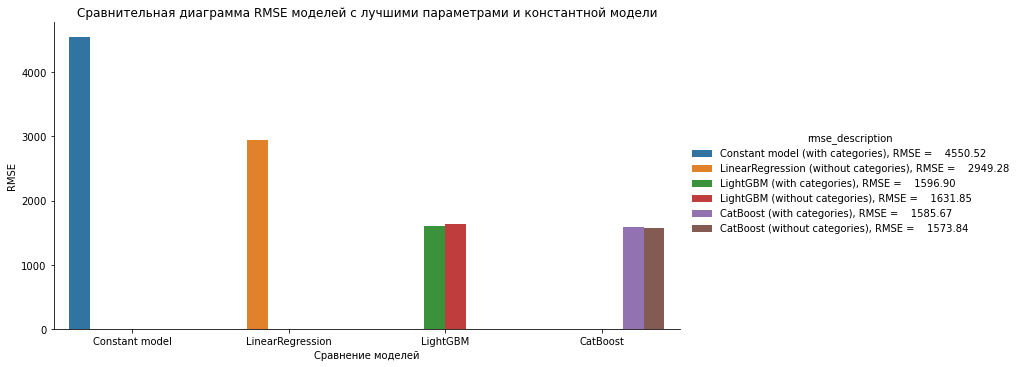

In [78]:
# построим график сравнения RMSE для трех моделей (включая константную)

g = sns.catplot(x="model_name", 
            y="rmse",
            hue="rmse_description", 
            kind="bar", 
            data=compare_data_models_for_best_model,
            ci=None, 
            aspect=2,
            height=5
            )

g.set_axis_labels("Сравнение моделей", "RMSE")
g.ax.set_title("Сравнительная диаграмма RMSE моделей с лучшими параметрами и константной модели")

<span style="color:green">Лучшее значение **RMSE** для **LightGBM** - **1596.90**. Причем это значение достигнуто на непреобразованном датасете.<span>

<span style="color:green">Лучшее значение **RMSE** для **CatBoost** - **1573.84**. В этом случае модель повела себя лучше на преобразованном датасете.<span>
    
<span style="color:blue">**LinearRegression** существенно проигрывает в точности - **2949.28**.<span>
    
<span style="color:red">По параметру **RMSE**, **CatBoost** выигрывает, но с минимальным отрывом и обе модели получают по **3 балла**.<span>
    
<span style="color:green">Теперь сравним две лучшие модели по остальным параметрам.<span>

Text(0.5, 1.0, 'Сравнительная диаграмма времени предсказания моделей с лучшими параметрами')

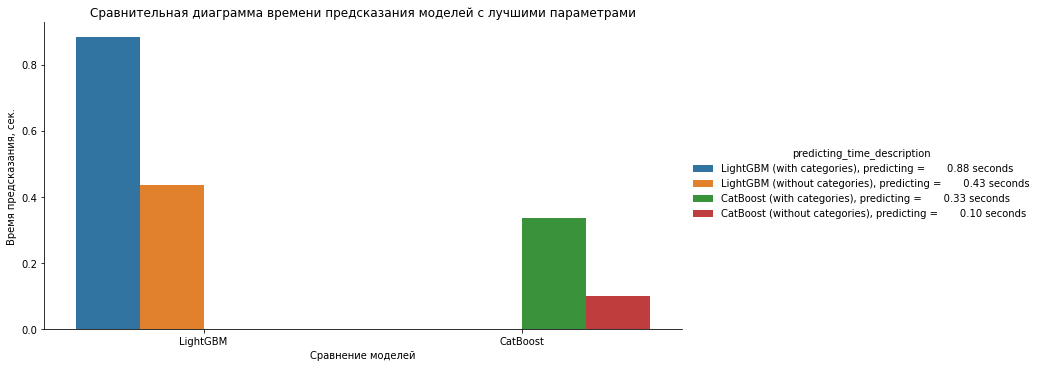

In [79]:
# построим график сравнения времени предсказания для двух моделей

g = sns.catplot(x="model_name", 
            y="predicting_time",
            hue="predicting_time_description", 
            kind="bar", 
            data=compare_data_models_for_best_model.query('(model_name != "Constant model")&(model_name != "LinearRegression")'),
            ci=None, 
            aspect=2,
            height=5
            )

g.set_axis_labels("Сравнение моделей", "Время предсказания, сек.")
g.ax.set_title("Сравнительная диаграмма времени предсказания моделей с лучшими параметрами")

Text(0.5, 1.0, 'Сравнительная диаграмма времени обучения моделей с лучшими параметрами')

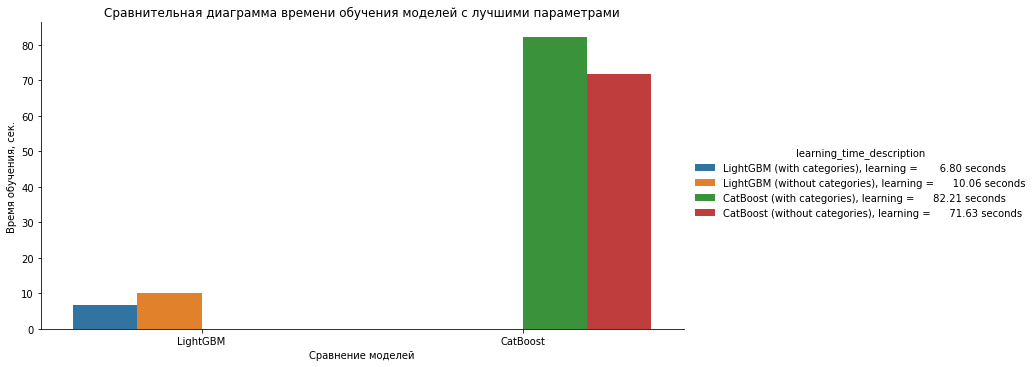

In [80]:
# построим график сравнения времени обучения для двух моделей

g = sns.catplot(x="model_name", 
            y="learning_time",
            hue="learning_time_description", 
            kind="bar", 
            data=compare_data_models_for_best_model.query('(model_name != "Constant model")&(model_name != "LinearRegression")'),
            ci=None, 
            aspect=2,
            height=5
            )

g.set_axis_labels("Сравнение моделей", "Время обучения, сек.")
g.ax.set_title("Сравнительная диаграмма времени обучения моделей с лучшими параметрами")

### <span style="color:green">Выводы по результатам анализа моделей<span>

Рейтинг модели **lightGBM**: 3 балла - за RMSE, 1 балл - за время предсказания и 2 балла за время обучения. Всего - **6 баллов.**

Рейтинг модели **CatBoost**: 3 балла - за RMSE, 3 балла - за время предсказания и 1 балл за время обучения. Всего - **7 баллов.**
    
В итоге с перевесом в 1 балл выигрывает CatBoost.
    
### <span style="color:red">Модели достаточно близки по точности предсказания, однако скорость предсказания модели CatBoost в 2 разав выше, что в высоконагруженных системах приведет к существенному повышению производительности. Даже при том, что время обучения CatBoost существенно выше, чем lightGBM, мы рекомендуем использование **CatBoost**.<span>

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей